In [7]:
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import preprocessing
import csv
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import models

In [9]:
file_path = "train_data.csv"

# Initialize arrays
y_labels = []
x_TS = []

# Read the CSV file line by line
with open(file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    
    next(csv_reader)
    
    # Extract the first column and construct rows as arrays
    for row in csv_reader:
        y_labels.append(row[0])
        x_TS.append(row[1:])

[ 45.   45.5  46.   46.5  47.   47.5  48.   48.5  49.   49.5  50.   50.5
  51.   51.5  52.   52.5  53.   53.5  54.   54.5  55.   55.5  56.   56.5
  57.   57.5  58.   58.5  59.   59.5  60.   60.5  61.   61.5  62.   62.5
  63.   63.5  64.   64.5  65.   65.5  66.   66.5  67.   67.5  68.   68.5
  69.   69.5  70.   70.5  71.   71.5  72.   72.5  73.   73.5  74.   74.5
  75.   75.5  76.   76.5  77.   77.5  78.   78.5  79.   79.5  80.   80.5
  81.   81.5  82.   82.5  83.   83.5  84.   84.5  85.   85.5  86.   86.5
  87.   87.5  88.   88.5  89.   89.5  91.   91.5  92.   92.5  93.   93.5
  94.   94.5  95.   95.5  96.   96.5  97.   97.5  98.   98.5  99.   99.5
 100.  100.5 101.  101.5 102.  102.5 103.  103.5 104.  104.5 105.  105.5
 106.  106.5 107.  107.5 108.  108.5 109.  109.5 110.  110.5 111.  111.5
 112.  112.5 113.  113.5 114.  114.5 115.  115.5 116.  116.5 117.  117.5
 118.  118.5 119.  119.5 120.  120.5 121.  121.5 122.  122.5 123.  123.5
 124.  124.5 125.  125.5 126.  126.5 127.  127.5 12

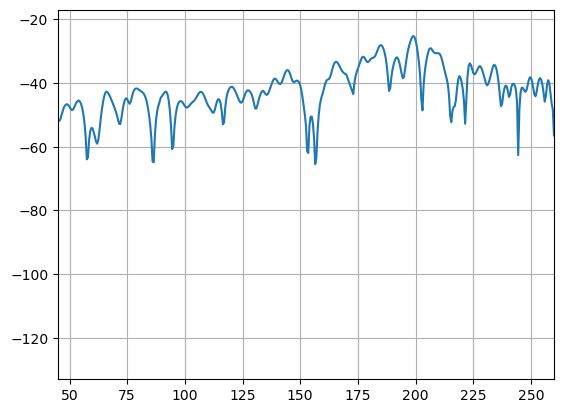

In [16]:
TS_array = np.array(x_TS[0])
TS_array = np.array(TS_array, dtype=float)

# Create an array of x values
x_values = np.arange(45,260.5,0.5)
elements_to_remove = [90.0, 90.5, 170.5, 171.0, 171.5, 172.0, 172.5]
x_values = x_values[~np.isin(x_values, elements_to_remove)]
print(x_values)


# Plot the graph for the first time ping
plt.plot(x_values, TS_array, linestyle='-')
plt.xlim(45, 260)
plt.ylim(-133, -17)
plt.grid(True)
plt.savefig('TS_Freq_1.png')
plt.show()

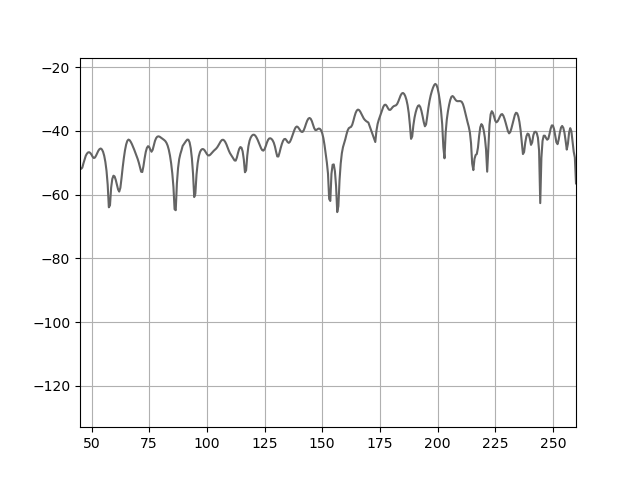

In [10]:
# Get gray image
image = Image.open('TS_Freq_1.png')
gray_image = image.convert('L')
gray_image

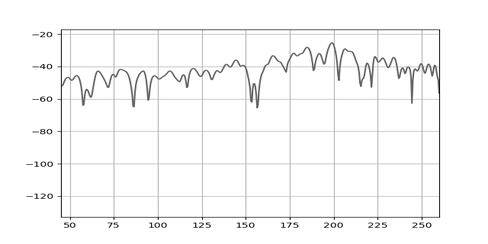

In [20]:
# Resize gray image based on the code from original paper
gray_image = gray_image.resize((488, 244), Image.LANCZOS)
gray_image

In [11]:
# Turn gray image into an array indicating pixels
im_as_arr = np.float32(gray_image) # Q: will the axis labels affect the values?
im_as_arr = np.expand_dims(im_as_arr, axis=2)
# print(im_as_arr.shape) # Height = 244, width = 244 , channel = 1 (gray scale)

im_as_arr = im_as_arr.transpose(2, 1, 0)  # Convert array to D,W,H
im_as_arr.shape

(1, 640, 480)

In [12]:
# Normalize the channels

# Mean and std adapted from the original study
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Normalize the channels
for channel, _ in enumerate(im_as_arr):
    im_as_arr[channel] /= 255
    im_as_arr[channel] -= mean[channel]
    im_as_arr[channel] /= std[channel]
    
print(im_as_arr)

[[[2.2489083 2.2489083 2.2489083 ... 2.2489083 2.2489083 2.2489083]
  [2.2489083 2.2489083 2.2489083 ... 2.2489083 2.2489083 2.2489083]
  [2.2489083 2.2489083 2.2489083 ... 2.2489083 2.2489083 2.2489083]
  ...
  [2.2489083 2.2489083 2.2489083 ... 2.2489083 2.2489083 2.2489083]
  [2.2489083 2.2489083 2.2489083 ... 2.2489083 2.2489083 2.2489083]
  [2.2489083 2.2489083 2.2489083 ... 2.2489083 2.2489083 2.2489083]]]


In [13]:


# Convert to float tensor
im_as_ten = torch.from_numpy(im_as_arr).float()

# ? Add one more channel to the beginning. Tensor shape = 1,3,224,224
im_as_ten.unsqueeze_(0)

# Convert to Pytorch variable
im_as_var = Variable(im_as_ten, requires_grad=True)

# A reference of the original method

In [ ]:
def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((20, 20), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var